In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import random
import os
from concurrent.futures import ThreadPoolExecutor
import zipfile


# Povezivanje na Google Drive
from google.colab import drive
drive.mount("/content/drive")



# Putanja do ZIP fajla Dataset.zip
zip_file_path = "/content/drive/MyDrive/[POOS] - Projekat/Dataset.zip"

local_extract_path = "/content/local_data"

if not os.path.exists(local_extract_path):
    print(f"Raspakivanje podataka sa Drive-a na lokalni disk...")
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(local_extract_path)
        print("Raspakivanje uspješno!")
    except FileNotFoundError:
        print(f"GREŠKA: Nepostojeći fajl: {zip_file_path}")
        print("Provjeri ime fajla i putanju!")
else:
    print("Podaci su već raspakovani.")

#  POSTAVLJANJE NOVIH PUTANJA
if "Train.csv" in os.listdir(local_extract_path):
    base_path = local_extract_path + "/"
elif "Dataset" in os.listdir(local_extract_path):
    base_path = os.path.join(local_extract_path, "Dataset") + "/"
else:
    print("Provjera strukture foldera...")
    subfolders = [f.path for f in os.scandir(local_extract_path) if f.is_dir()]
    if subfolders:
        base_path = subfolders[0] + "/"
    else:
        base_path = local_extract_path + "/"

print(f"Nova lokalna putanja (base_path): {base_path}")

# Definisanje putanja do CSV fajlova
meta_data_path = os.path.join(base_path, "Meta.csv")
train_data_path = os.path.join(base_path, "Train.csv")
test_data_path = os.path.join(base_path, "Test.csv")

# Provjera da li fajlovi postoje
if not os.path.exists(train_data_path):
    print(f"Train.csv nije pronađen na: {train_data_path}")
    print("Provjeri sadržaj zip fajla.")

print("Broj dostupnih GPU: ", len(tf.config.list_physical_devices('GPU')))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Podaci su već raspakovani.
Nova lokalna putanja (base_path): /content/local_data/Dataset/
Broj dostupnih GPU:  0


In [ ]:
# Učitavanje CSV fajlova
meta_data = pd.read_csv(meta_data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Sampling
train_data_opt = train_data.groupby("ClassId", group_keys=False).apply(lambda x: x.sample(min(len(x), 100), random_state=42))

def load_and_preprocess_image(image_path):
    full_path = base_path + image_path
    try:
        img = Image.open(full_path)
        img = img.convert('RGB')
        img = img.filter(ImageFilter.EDGE_ENHANCE)
        img = img.resize((45, 45))
        img = np.array(img) / 255.0
        return img
    except Exception as e:
        return None

print("Učitavanje slika...")

def process_row(row):
    return load_and_preprocess_image(row['Path']), row['ClassId']

processed_images = []
labels = []

with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(process_row, train_data_opt.to_dict('records')))

for img, label in results:
    if img is not None:
        processed_images.append(img)
        labels.append(label)

print(f"Učitano {len(processed_images)} slika.")

# Pretvaranje u numpy
X_train = np.array(processed_images)
y_train = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Podaci spremni za trening.")

/tmp/ipython-input-1655825533.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data_opt = train_data.groupby("ClassId", group_keys=False).apply(lambda x: x.sample(min(len(x), 100), random_state=42))


Učitavanje slika...
Učitano 4300 slika.
Podaci spremni za trening.


In [ ]:
device_name = '/device:GPU:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

with tf.device(device_name):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(45, 45, 3)),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(43, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    )

    print("Početak treniranja...")
    history = model.fit(
        X_train, y_train,
        epochs=35,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        batch_size=64
    )

Započinje treniranje...
Epoch 1/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.0493 - loss: 3.8478 - val_accuracy: 0.1837 - val_loss: 3.6495
Epoch 2/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 325ms/step - accuracy: 0.3286 - loss: 2.4247 - val_accuracy: 0.6395 - val_loss: 3.1812
Epoch 3/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 362ms/step - accuracy: 0.6286 - loss: 1.2237 - val_accuracy: 0.8023 - val_loss: 2.8406
Epoch 4/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.7901 - loss: 0.6618 - val_accuracy: 0.8860 - val_loss: 2.2248
Epoch 5/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.8566 - loss: 0.4562 - val_accuracy: 0.9105 - val_loss: 1.7357
Epoch 6/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.8950 - loss: 0.3310 - val_accuracy: 0.9465 - val_loss: 1.0228
Epoch 7/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.9310 - loss: 0.2394 - val_accuracy: 0.9419 - val_loss: 0.8977
Epoch 8/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 387ms/step - accuracy: 0.9399 -

Uploaduj sliku saobraćajnog znaka: 


Saving stop.png to stop (1).png


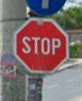


Rezultati predikcije:
ID klase znaka: 14
Saobraćajni znak: Stop
Confidence: 71.01%


In [ ]:
from google.colab import files
from IPython.display import display
from PIL import Image, ImageFilter
import numpy as np
import tensorflow as tf

# Mapiranje ClassId u naziv znaka
CLASSES = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

def preprocess_image(img):
    img = img.convert("RGB")
    img = img.filter(ImageFilter.EDGE_ENHANCE)
    img = img.resize((45, 45))
    img = np.array(img) / 255.0
    return np.expand_dims(img, axis=0)

print("Uploaduj sliku saobraćajnog znaka: ")
uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name)
    display(img)

    x = preprocess_image(img)
    preds = model.predict(x, verbose=0)

    class_id = int(np.argmax(preds))
    confidence = float(np.max(preds))
    sign_name = CLASSES.get(class_id, "Nepoznat znak")

    print("\n==============================")
    print("Rezultati predikcije:")
    print("==============================")
    print(f"ID klase znaka: {class_id}")
    print(f"Saobraćajni znak: {sign_name}")
    print(f"Confidence: {confidence * 100:.2f}%")

